# InfraTESS
### Madison Brady

In this notebook, I will study the feasibility of using an all-sky TESS-like survey in the IR to study the signatures of transiting exoplanets around brown dwarfs. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import pandas as pd
from scipy.interpolate import *
import os
import re
from matplotlib import cm
import lightkurve as lk
import math
from IPython.core.display import Image, display


First, in the absence of a full complete set of data on brown dwarf populations (at least that I can find), I will perform a statistical simulation of brown dwarfs in order to determine what magnitudes my instrument will need to be sensitive to.


To model the masses of the population, I will use the stellar IMF (initial mass function) from [Muzic et al. (2019)](https://arxiv.org/pdf/1907.00617.pdf), which was found by performing a survey of a massive young cluster:

$\frac{dN}{dM} \propto M^{-1.03}$, $0.02 M_\odot < M < 0.4 M_\odot$


$\frac{dN}{dM} \propto M^{-2.12}$, $0.4 M_\odot < M < 7 M_\odot$

It is relatively simple to write a function that simulates a sample of objects according to this IMF:

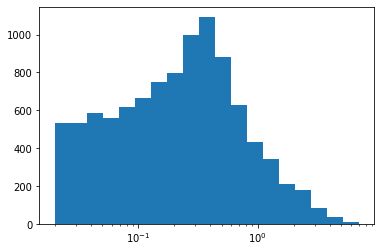

In [2]:
def sample_imf(lam1, lam2, mmin, mmid, mmax, nsamps, plot=True):
    """
    Generate nsamp masses sampled from an IMF with the form:
    
    dN/dM propto M^(lam1) + constant, mmin<M<mmid
    dN/dM propto M^(lam2) + constant, mmid<M<mmax
    
    """
    
    # Just some additive constants.
    d = - mmax**lam2
    c = mmid**lam2 + d - mmid**lam1
    
    masses_all = np.linspace(mmin, mmax, 10000)
    
    # Calculate pdf.
    f_all = np.zeros(len(masses_all))
    f_all[masses_all<mmid] = (masses_all[masses_all<mmid]**lam1 + c)
    f_all[masses_all>mmid] = (masses_all[masses_all>mmid]**lam2 + d)
    
    # Create cdf from pdf.
    cdf = np.cumsum(f_all)/np.max(np.cumsum(f_all))
    
    # generate nsamps uniformly sampled numbers between 0 and 1.
    u = np.random.uniform(size=nsamps)
    
    # Use cdf to find masses associated with uniformly sampled numbers.
    masses = masses_all[np.searchsorted(cdf, u)]

    
    if plot==True:
    
        plt.hist(masses, bins=np.logspace(np.log10(0.02), np.log10(7), base=10, num=20))
        plt.xscale("log")
    
    return masses
  
    
# Test, to see that it works.
masses = sample_imf(-1.03, -2.12, 0.02, 0.4, 7, 10000)

So, now that we can generate a sample of stellar and brown dwarf masses, let's think about calibrating this relationship such that we can generate samples that roughly line up with real-world number counts of objects.

Let's consider the number of objects within 15 pc.  There are roughly 512 M dwarfs (masses between 0.1 and 0.3) in the sample from [Winters et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021AJ....161...63W/abstract), which is stated to be complete.  So, let's figure out what nsamps in the statement above needs to be in order to get the number of M dwarfs as being 512.

In [3]:
# Some quick functions.

def n_m_dwarf(masses):
    return len(np.where((masses>=0.1)&(masses<=0.3))[0])

def n_brown_dwarf(masses):
    return len(np.where(masses<0.08)[0])

# Figure out how many M dwarfs there are from our nsamp=10000 calculation.
nm = n_m_dwarf(masses)

# Perform an extimation of the number of total samples necessary to get
# there to be 512 M dwarfs.
nsamps_15pc = int(10000 * 512/nm)

# Setting nsamps to this value, we can check and make sure we actually
# do generate roughly 512 M dwarfs.
masses_15pc = sample_imf(-1.03, -2.12, 0.02, 0.4, 7, nsamps_15pc, plot=False)
print("We generate", n_m_dwarf(masses_15pc), "M dwarfs, compared to the desired 512.")


We generate 509 M dwarfs, compared to the desired 512.


That value seems close enough to 512 that I'm pretty happy with it.  We can thus use this 15 pc sample as a benchmark, allowing us to probe the number of brown dwarfs out to various distances.  This is interesting with regards to our desire to determine, e.g., the number of brown dwarfs our survey can reach.

In [4]:
def sample_imf_distance(distance, lam1, lam2, mmin, mmid, mmax, nsamps_15pc):
    
    """
    Sample the aforementioned IMF out to a desired distance, in pc.
    
    """
    
    nsamps_distance = int((distance/15)**3 * nsamps_15pc)
    
    masses = sample_imf(lam1, lam2, mmin, mmid, mmax, nsamps_distance)
    
    return masses



So, we now know the masses.  But how do brown dwarf masses compare with luminosities?  We can use the grid of models from [Marley et al. (2021)](https://zenodo.org/record/5063476#.Yoj6DjnMJH4), which calculated how brown dwarf temperatures, surface gravities, radii, ages, masses, and luminosities varied together.  We can use these to construct functions of how the brown dwarf luminosity varies with mass.  This requires reading in some data.

In [5]:
# Read in the models.
grid = pd.read_csv("nc+0.0_co1.0_mass", sep="\s+")
grid = grid.dropna(axis=0)

# Read in the data from the pandas dataframe.
teffs = np.array(grid["Teff(K)"])
loggs = np.array(grid["logg"])
masses = np.array(grid["M/Msun"])
rads = np.array(grid["R/Rsun"])
ages = np.array(grid["age(Gyr)"])*10**9
lums = np.array(grid["logL/Lsun"])

# Use the scipy LinearNDInterpolator to create functions
# that allow us to calculate the luminosity, radius, etc just
# given the mass and age of the brown dwarf. 
l_function = LinearNDInterpolator((masses, ages), lums)
teff_function = LinearNDInterpolator((masses, ages), teffs)
logg_function = LinearNDInterpolator((masses, ages), loggs)
rad_function = LinearNDInterpolator((masses, ages), rads)



Now, let's generate a sample of brown dwarfs out to some arbitrarily high distance (we'll be only interested in the closest, brightest ones that we can actually observe, after all).  

We can then randomly generate distances for each one.  If we plug the generated masses into the luminosity equation and assume that the brown dwarfs near our sun have ages randomly distributed between about 1 Gyr and 15 Gyr (which is where the models cover all masses- the models do cover younger brown dwarfs, but only those at very low masses for some reason).

**Running this cell will take a little while (~20s).**

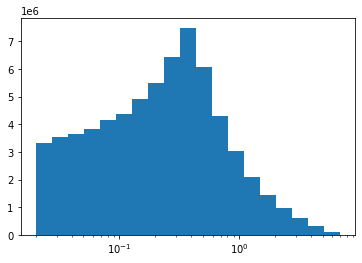

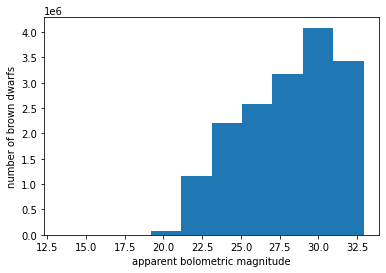

In [6]:
dmax = 500

masses = sample_imf_distance(dmax, -1.03, -2.12, 0.02, 0.4, 7, nsamps_15pc)
masses_bd = masses[np.where(masses<0.08)]



n = len(masses_bd)
x = np.random.uniform(0, dmax, n)
y = np.random.uniform(0, np.sqrt(dmax**2-x**2), n)
z = np.random.uniform(0, np.sqrt(dmax**2-x**2-y**2), n)
r = np.sqrt(x**2+y**2+z**2)

age = np.random.uniform(10**9, 15*10**9, n)


#Apparent bolometric magnitude.
m = 4.83 - 2.5 * l_function(masses_bd, age) + 5 * np.log10(r/10)
teff = teff_function(masses_bd, age)
logg = logg_function(masses_bd, age)
rad = rad_function(masses_bd, age)
plt.show()
plt.hist(m)

plt.xlabel("apparent bolometric magnitude")
plt.ylabel("number of brown dwarfs")
plt.show()



Of course, we don't observe bolometric magnitude- we observe brown dwarfs in bands.  I will construct a function here to describe the percentage of a brown dwarf's flux is in a user-defined band, using (once again), the models of [Marley et al. (2021)](https://zenodo.org/record/5063476#.Yoj6DjnMJH4).




In [7]:
# These are just some functions to read in the models.  

def load_model(
    model_filename,
    ):
    """
    Loads in a sonora model.
    """

    df = pd.read_csv(model_filename, skiprows=2, sep="\s+", names=("wl", "fx"))
    wl = np.array(df.wl)
    fx = np.array(df.fx)
    
    idx = np.argsort(wl)
    wl = wl[idx]
    fx = fx[idx]

    return wl, fx


def load_model_list(model_folder,temp_limits,logg_limits,feh_limits,):
    """
    Loads in all sonora models from a folder.  Only includes models with
    temperatures, surface gravities,and metallicities in a desired range.
    """
    files = [model_folder + i for i in os.listdir(model_folder) if "sp_t" in i]

    temp_arr = np.zeros(len(files))
    logg_arr = np.zeros(len(files))
    feh_arr = np.zeros(len(files))

    n = 0

    for i in range(len(files)):

        temp = float(re.search("sp_t(.*?)g", files[i]).group(1))
        logg = np.log10(float(re.search("g(.*?)nc_m", files[i]).group(1))*100)
        try:
            feh = float(re.search("nc_m(....)", files[i]).group(1))
        except:
            feh = float(re.search("nc_m(...)", files[i]).group(1))

        if (
            temp < temp_limits[0]
            or temp > temp_limits[1]
            or logg < logg_limits[0]
            or logg > logg_limits[1]
            or feh < feh_limits[0]
            or feh > feh_limits[1]
        ):  # Model not in range
            pass
        
        else:
            if n == 0:
                wl, fx = load_model(files[i])
                fx_all = np.zeros((len(files), len(fx)))
                fx_all[n] = fx

            else:
                _, fx_all[n] = load_model(files[i])
                
            temp_arr[n] = temp
            logg_arr[n] = logg
            feh_arr[n] = feh
            n += 1

    # Reindex to account for models that aren't in our region of interest.
    temp_arr = temp_arr[:n]
    logg_arr = logg_arr[:n]
    feh_arr = feh_arr[:n]

    fx_all = fx_all[:n]
        
        
    return (
        wl, fx_all, temp_arr, logg_arr, feh_arr
    )


class ModelSpectra:
    """
    Class for storing models in.
    
    """
    
    def __init__(
        self,
        model_folder,
        temp_limits,
        logg_limits,
        feh_limits,
    ):


        self.model_folder = model_folder

        wl, fx_all, temp_arr, logg_arr, feh_arr = load_model_list(
        model_folder,
        temp_limits,
        logg_limits,
        feh_limits,
        )

        self.wl = wl
        self.fx = fx_all
        
        
        
        self.temps = temp_arr
        self.loggs = logg_arr
        self.fehs = feh_arr
        self.n_models = len(self.fehs)
        
        # Finds the normalization of each model.
        self.totfluxes = np.zeros(self.n_models)
        for i in range(self.n_models):
            self.totfluxes[i] = integrate.simpson(self.fx[i], self.wl)
    
    
    def find_band_dM(self, wl_min, wl_max):
        """
        Determines the change in magnitude from bolometric
        you get from each model if you only consider a certain band of
        wavelengths instead of observing the entire spectrum.
        """
            
        idx = np.where((self.wl>=wl_min)&(self.wl<=wl_max))
        dM = np.zeros(self.n_models)
            
        for i in range(self.n_models):
                # Finds the percentage of the models' flux that is in a given 
                # band of wavelengths.
                band_flux = integrate.simpson(self.fx[i][idx], self.wl[idx])
                
                # Converts this flux percentage to a change in magnitude.
                dM[i] = -2.5 * np.log10(band_flux/self.totfluxes[i])
            
        return dM

**Warning.  The following cell will not work unless you go to [this page](https://zenodo.org/record/5063476#.Yo_X2jnMJH5) and download the file named** spectra_m+0.0.tar.gz
 **and place its contents inside the folder called "brown_dwarf_spectra" in the code folder.  It was too big to put on github.**
 
 **This cell will also take around 20s to run.**

In [8]:
# Load in an array of models.  Let's not consider metallicity for now.
temp_limits = [np.min(teff)-100, np.max(teff)+100]
logg_limits = [np.min(logg)-.25, np.max(logg)+0.25]
feh_limits = [0, 0]
models = ModelSpectra("brown_dwarf_spectra/", temp_limits, logg_limits, feh_limits)

Now, let's make a plot that shows how limiting ourselves to certain bands affect the apparent magnitude of the object.

I will also in this section define two adjustable bands whose properties I will be exploring with regards to actually using them as the final bandpasses of the instrument. I'm interested in using two bands with somewhat complimentary sensitivity when it comes to actually detecting stuff.

Using two bands is also helpful when disentangling planets and activity, as stellar activity is expected to have strong wavelength dependence while planetary transits have very weak wavelength dependence (unless you're looking at particular absorption lines).

Usually, in ground-based observatories, IR passbands are selected based on where there are windows of absorption in the Earth's atmosphere.  I have no such worries, since my hypothetical instrument is in space. I will thus make them as wide as possible, in order to allow for maximal photon collection.

With regards to wavelength coverage, I consider what has been used in JWST.  JWST has two different types of detectors: 

- the 0.6-5 $\mu$m HgCdTe detectors, used for most of the instruments, with an operating temperature of 37 K.

- the 5-28 $\mu$m Si:As detectors, used by MIRI.  These require a cooling system to reduce the instrument down to temperatures below about 7 K.

It appears that, if we want to recycle knowledge from JWST to reduce costs, we would need two different kinds of chips on our instrument (as well as a fairly involved cooling system) to get $\lambda>5 \mu$m.  So let's see what we can do to limit that, by keeping our two bands between $0.6-5 \mu$m. 


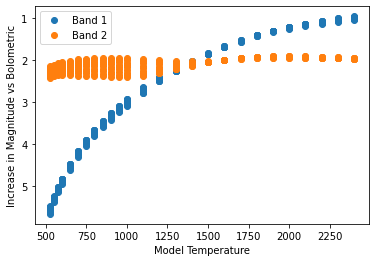

In [9]:

band1 = [0.6, 3.5]
band2 = [3.5, 5]
dM_b1 = models.find_band_dM(band1[0], band1[1])
dM_b2 = models.find_band_dM(band2[0], band2[1])


plt.plot(models.temps, dM_b1, "o", label="Band 1")
plt.plot(models.temps, dM_b2, "o", label="Band 2")

plt.xlabel("Model Temperature")
plt.ylabel("Increase in Magnitude vs Bolometric")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

We see here that the bluer band 1 allows for more sensitivity to hotter brown dwarfs, while the redder band 2 allows for more sensitivity to cooler brown dwarfs.  These two bands seem reasonably complimentary, and as a bonus could be read using the same sort of detector chip.

As the next step, we can create an interpolator that allows us to connect the models to this change in magnitude, which should allow us to directly estimate the band magnitudes of our simulated sample of brown dwarfs.

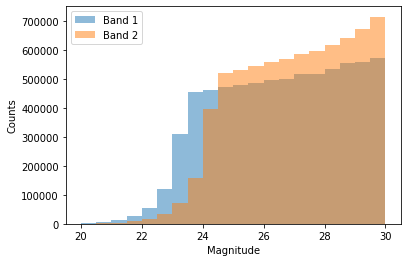

In [10]:
b1_function = LinearNDInterpolator((models.temps, models.loggs), dM_b1)
b2_function = LinearNDInterpolator((models.temps, models.loggs), dM_b2)

m_b1 = m+b1_function(teff, logg)
m_b2 = m+b2_function(teff, logg)

plt.hist(m_b1, range=(20, 30), bins=20,  label="Band 1", alpha=0.5)
plt.hist(m_b2, range=(20, 30), bins=20, label="Band 2", alpha=0.5)
plt.legend()
plt.xlabel("Magnitude")
plt.ylabel("Counts")
plt.show()

Let's now see how a given magnitude affects how observable a given target is.  We can do this by converting the magnitude to a flux of photons (in units of number of photons per area per second), and use that to determine how many photons from a given target our detector (of a certain size) would be able to "see" given an exposure length.  To do so, we use the following methodology.

First, we find the flux in each bands, using the relation
$$f_1 = f_2 10^{-0.4(m_1-m_2)}$$
where the $f$s are the fluxes (in erg/s/cm$^2$) and the $m$s are the magnitudes.  We will use the sun as a reference object.

Second, we estimate $f_\lambda$ (flux as a function of wavelength) with the follwing relationship:
$$f_\lambda \approx \frac{f_{tot}}{\Delta \lambda}$$

Where $\Delta \lambda$ is the instrument's bandpass.

We want to estimate the number of photons reaching our instrument with the following relation:

$$n_{tot} = A t_{exp} \int \frac{f_\lambda}{h c/\lambda} d\lambda$$

where $A$ is the area of the aperture and $t_{exp}$ is the exposure length.

performing integration, we find that

$$n_{tot} = \frac{A t_{exp} f_{\lambda, avg}}{h c} \int \lambda d\lambda$$

$$n_{tot} = \frac{A t_{exp} f_{\lambda, avg}}{2 h c} (\lambda_{max}^2-\lambda_{min}^2)$$

If we assume poisson errors on the number of photons arriving, we find that the signal-to-noise ratio (purely from photon noise) of our telescope is roughly equivalent to $\sqrt{n_{tot}}$.

For our purposes here, we will adopt 1m as an upper limit on our aperture.  Ths requirement comes from the fact that we're interested in using refractive lenses for this project, and 1m is a practical upper limit on how large such lenses can be.

We will let the exposure length to be roughly equivalent to 5 minutes, which seems about as long as we can get the exposures while also reasonably expecting to be able to detect the signatures of planets with transit durations on the order of 1 hour.

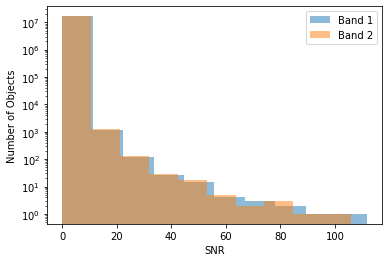

In [11]:
# Find the fluxes.
flux_solar = 1373* 1000 # erg/s/cm^2

flux_b1 = flux_solar * 10**(-0.4 * (m_b1+26.74))
flux_b2 = flux_solar * 10**(-0.4 * (m_b2+26.74))


# Let's operate under the assumption that each band can be represented
# by the following:
# f_lambda, avg = f_tot/d lambda
db1 = band1[1]-band1[0]
db2 = band2[1]-band2[0]

flux_lambda_b1 = flux_b1/db1
flux_lambda_b2 = flux_b2/db2

# Now, let's calculate the total number of photons in each
# band, assuming that 
# n_tot = integrate(f_lambda/E_lambda) dlambda * area * texp
# Where E_lambda = hc/lambda
# Which gets us
# n_tot = 1/2 f_lambda/hc (lambda_max^2-lambda_min^2)
h = 6.626e-27
c = 2.9979e10

band1_cm = np.array(band1)*1e-4
band2_cm = np.array(band2)*1e-4

texp = 300 # Exposure time, in seconds.
mirror_diameter = 1 * 100 # cm.  This is on the order of the maximum lens size we can realistically expect.
area = np.pi * (mirror_diameter/2)**2 # area of mirror, in cm^2


n_b1 = 1/2 * flux_lambda_b1 / h / c * (band1_cm[1]**2-band1_cm[0]**2) * texp * area
n_b2 = 1/2 * flux_lambda_b2 / h / c * (band2_cm[1]**2-band2_cm[0]**2) * texp * area


# Find the SNR, which is just equivalent to the poisson noise of the 
# number counts- N/sqrt(N)
snr_b1 = np.sqrt(n_b1)
snr_b2 = np.sqrt(n_b2)


#bins = np.linspace(0, 500, 20)
_ = plt.hist(snr_b1, alpha=0.5, label="Band 1")
_ = plt.hist(snr_b2, alpha=0.5, label="Band 2")
plt.xlabel("SNR")
plt.ylabel("Number of Objects")
plt.legend()
plt.yscale("log")
plt.show()


Now, recall that this is just the signal-to-noise ratio purely from errors in the number of photons from the star.  We also need to consider the instrumental systematics to make this work.

To do so, we can take advantage of the studies used to evaluate the noise properties of the NIRCAM instrument, which uses the same detector chip as us. [Schlawin et al. (2021)](https://iopscience.iop.org/article/10.3847/1538-3881/abd8d4/pdf) found that the NIRCAM detector had a noise floor of around 9 ppm from antenna motions, thermal instabilities in the optics, charge-trapping in the detector, and temperature fluctuations.  If we adopt a cooling system akin to that from JWST, we could presumably achieve similarly low amounts of noise. The study also notes there may be long-term errors on the order of 40 ppm, so we will conservatively adopt a 50 ppm systematic noise when estimating the detectability of planets.


The detector also has a readout time of about 11 seconds, which is releveant when generating observations.


Now, let's generate a light curve assuming the existence of such noise terms, and find the minimal planetary radius that could be detected around such a star.  We will say anything with a transit SNR > 10 is detectable.  We note that this is a higher cutoff SNR than what is required by TESS (7.1), as this study does not take into account any additional terms in the noise that could be important, such as noise from activity.  We don't do this because we currently don't have any great means to determine the actual light curve variance due to brown dwarf surface processes in the IR, as this is not currently well-studied.

There are 0 BDs around which we could see <=1 REarth planets.
There are 58 BDs around which we could see <=2 REarth planets.
There are 3138 BDs around which we could see <=4 REarth planets.
There are 973202 BDs around which we could see <=10 REarth (RJup) planets.


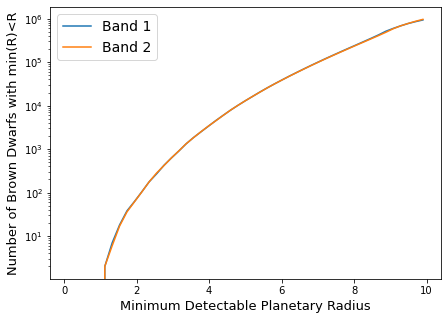

In [12]:
def generate_lc(snr, cadence=(120+11)/60/60/24, sector_len=27):
    
    """
    Generates light curve data.
    
    cadence: float, the cadence of the observations in days, defaulted to 
    2 minutes + 11s readout time.
    snr: SNR of spectrum, from photon noise.
    sector_len: Length of sector, in units of days.  default is 27,
    the length of a TESS sector.
    
    """
    
    t = np.arange(0, sector_len, cadence)
    
    fx_err = np.ones(len(t)) * (1/snr)
    
    fx = np.ones(len(t)) + np.random.randn(len(t)) * fx_err
    
    return t, fx, fx_err



def min_rp(snr, rad, snr_cutoff=7.1, systematic_noise=50/10**6, ):
    """
    Determines the minimum detectabble planetary radius, in Earth
    radii, of a set of input band SNRs.  Assumes a transit length 
    of 1 hour.
    
    snr = object SNRs.
    rad = Stellar radii, in Rsolar.
    snr_cutoff = the cutoff SNR at which an object is "detectable"
    in the noise.  7.1 is the defined SNR for TESS.  The scientists
    found that including a lower SNR cutoff resulted in a huge
    number of false positives in the dataset, so we'll adopt the same
    cutoff.  Future studies would include some sort of injection and
    recovery analysis to check this.
    systematic_noise: Noise of the detector. Defaults to 50 ppm.
    """
    
    # Makes a SNR=100 light curve.
    t, fx, fx_err = generate_lc(100)
    lc = lk.LightCurve(time=t, flux=fx, flux_err=fx_err)
    
    # Uses lightkurve to estimate the 1 hour cdpp noise 
    # of the light curve, in ppm.
    hr_cdpp_noise = np.sqrt(lc.estimate_cdpp(transit_duration=30)**2)
    
    # Presumably this noise scales with the inverse of the 
    # SNR.  So we'll perform that scaling based off of the
    # input SNRs (this step allows us to feed in an entire
    # array of SNRs without having to generate a light curve
    # for each).
    noise_snr = hr_cdpp_noise * 100/snr / 1e6
        
    
    tot_noise = np.sqrt(noise_snr**2 + systematic_noise**2)
    
    # The minimum detectable depth.
    min_depth = snr_cutoff * tot_noise 
    
    
    rsolar = 6.957e8
    rearth = 6.371e6
    
    min_rp = np.sqrt(min_depth) * rad * rsolar/rearth
    
    return(min_rp)


min_b1 = min_rp(np.array(snr_b1), np.array(rad), snr_cutoff=10)
min_b2 = min_rp(np.array(snr_b2), np.array(rad), snr_cutoff=10)

bins = np.linspace(0, 10)


plt.figure(figsize=(7, 5))
c, bins = np.histogram(min_b1, bins=bins)
plt.plot((bins[1:]+bins[:-1])/2, np.cumsum(c), label="Band 1")

c, bins = np.histogram(min_b2, bins=bins)
plt.plot((bins[1:]+bins[:-1])/2, np.cumsum(c), label="Band 2")

plt.yscale("log")

plt.xlabel("Minimum Detectable Planetary Radius", fontsize=13)
plt.ylabel("Number of Brown Dwarfs with min(R)<R", fontsize=13)
plt.legend(fontsize=14)

idx_obs = np.where((min_b1<=1)|(min_b2<=1))[0]
print("There are {} BDs around which we could see <=1 REarth planets.".format(len(idx_obs)))

idx_obs = np.where((min_b1<=2)|(min_b2<=2))[0]
print("There are {} BDs around which we could see <=2 REarth planets.".format(len(idx_obs)))

idx_obs = np.where((min_b1<=4)|(min_b2<=4))[0]
print("There are {} BDs around which we could see <=4 REarth planets.".format(len(idx_obs)))

idx_obs = np.where((min_b1<=10)|(min_b2<=10))[0]
print("There are {} BDs around which we could see <=10 REarth (RJup) planets.".format(len(idx_obs)))


TESS was able to observe around 50 short-period rocky planets around roughly 5000 M dwarfs (see, e.g., [Brady & Bean 2022](https://arxiv.org/abs/2112.08337)).  If we assume brown dwarfs have an occurrence rate less than that of M dwarfs (which is implied by that paper), we probably want to survey around that number of brown dwarfs at with a minimum detectable planetary radius of around 1 $R_\oplus$ in order to compare the occurrence statistics.

Unfortunately, it appears that we would need a substantially larger aperture in order to make this work, probably dramatically inflating the costs of the instrument.  As we would like to keep the mission costs manageable (in order to account for the general lack of interest in brown dwarfs in the astronomical community), we will have to instead focus our interests on objects in the sub-Neptune to hot Jupiter range, with $R_\oplus = 4$.  Thus, we adopt an aperture diameter of 1m for the rest of this work, noting that unfortunately our mission will be far more effective for planets that aren't rocky.

Now, let's consider how the observed population of objects with sub-Neptunes will look.

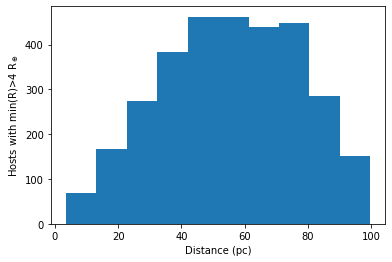

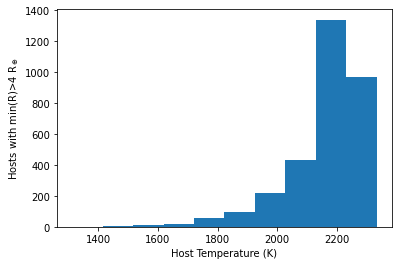

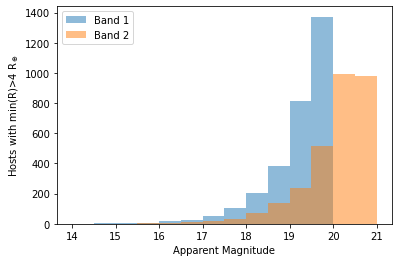

In [13]:
idx_obs = np.where((min_b1<=4)|(min_b2<=4))[0]
plt.hist(r[idx_obs])
plt.xlabel("Distance (pc)")
plt.ylabel("Hosts with min(R)>4 R$_\oplus$")
plt.show()

plt.hist(teff[idx_obs])
plt.xlabel("Host Temperature (K)")
plt.ylabel("Hosts with min(R)>4 R$_\oplus$")
plt.show()


bins=np.arange(14, 21.5, 0.5)
plt.hist(m_b1[np.where(min_b1<=4)[0]], label="Band 1", alpha=0.5, bins=bins)
plt.hist(m_b2[np.where(min_b2<=4)[0]], label="Band 2", alpha=0.5, bins=bins)
plt.xlabel("Apparent Magnitude")
plt.ylabel("Hosts with min(R)>4 R$_\oplus$")
plt.legend()
plt.show()


We see here that all detectable sub-Neptunes seem to fall below about 200 pc, retroactively justifying our usage of dmax=500 in our sample generation and the fact that we didn't account for reddening in our sample.  Additionally, as one may expect, the majority of detected sub-Neptunes will be found around the hottest (and thus brightest) brown dwarfs.

We also note that, while this mission won't be finding rocky planets around brown dwarfs, it does have a much deeper limiting magnitude in its bandpasses of choice (around 20) than TESS, which is operational around T magnitude 9-15.


Now let's consider what a mirror of that diameter will do to our angular resolution.  Recall the diffraction limit:

$$\Theta_{min}= \frac {1.22 \lambda} D $$

Plugging in values, we can find the diffraction limit:

In [14]:
b1_dlim = 1.22 * np.mean(band1)*1e-6 / (mirror_diameter*10**-2) * 206265
b2_dlim = 1.22 * np.mean(band2)*1e-6 / (mirror_diameter*10**-2) * 206265

print("The resolution in band 1 is {:.2f} arcseconds and the resolution in band 2 is {:.2f} arcseconds.".format(b1_dlim, b2_dlim))

The resolution in band 1 is 0.52 arcseconds and the resolution in band 2 is 1.07 arcseconds.


Now, let's check and see what our pixels can actually sample.

Typically, we can assume that the number of arc seconds per pixel is equivalent to:

$\theta = \frac{l_{pix}}{f} \times 206265$

Where $\theta$ is the number of arc seconds per pixel, $l_{pixel}$ is the width of the pixel, and $f$ is the focal length of the telescope.

In [15]:
pixel_length = 18*10**-6 # like JWST's pixels. In meters.
f_number = 0.6 # Minimal size
focal_length = f_number * mirror_diameter * 0.01  # In meters.

print("The focal length is {:.2f} meters.".format(focal_length))

pixel_size = pixel_length/(focal_length) * 206265 #in arcseconds.

print("The size of a pixel is about {:.2f} arcseconds.".format(pixel_size))

The focal length is 0.60 meters.
The size of a pixel is about 6.19 arcseconds.


The pixels are larger than the diffraction-limited resolution of the telescope.  We can't do any better than the pixel size.  

As a note, this number is substantially "better" than the pixel size of TESS, which was around 21 arcseconds.  As the TESS survey has been performing lots of useful transiting exoplanet science (often by making use of ground-based follow-up), it is reasonably safe to assume that this survey should do as well or better than TESS (at least in terms of its resolving power), as its pixels are smaller.

So, one may ask- why not decrease the pixel size, either by increasing the f number or by increasing the aperture diameter?  Now, let's consider the intention of this survey: to look at the whole sky.  If we mimic the TESS survey strategy (which seems to be a smart idea, as it allows us to reuse some of their calculations and lets our final collected data be more easily compared to their's in the optical), we want our observations to cover 24x96 degree strips of the sky.  Each strip would be observed for 27 days at a time, then the telescope would point to the next area.  However, considering our much smaller pixel size and much larger aperature, we don't really want to adopt the TESS strategy, in which they imaged different parts of the sky simultaneously with 4 10-cm cameras.  This is what allowed for such a large sky coverage so quickly.

Let's assume a strategy akin to TESS in terms of sector length, but with only two (instead of four) 24x24 degree images at a time.  This will effectively mean that this mission takes 2x longer than TESS to image the entire night sky, but its unique wavelength coverage, much deeper images, and higher resolution should provide some tradeoff.

Let's also follow along with TESS and adopt a four-aperature setup.  In this case, two aperatures will include a band 1 filter, and two will have a band 2 filter.  This allows for the simultaneous coverage without including some sort of splitter in the telescope optics.  Additionally, the aperatures will be split to cover a greater area of the sky, with one aperature of each filter pointed at one 24x24 degree area of sky and the remaining aperatures staring at the 12x24 degree area of sky directly beneath it.  


Now that we know the pixel sizes, we can ask: how many detector pixels do we need to reproduce this observation strategy?  And, from there, how many detector chips?  I've noticed that both the JWST and TESS use chips that are 2048x2048 pixels wide, which indicates to me that that is a fairly standard chip size.  So I'll assume we're using those.  So, let's see how many we end up needing.

In [16]:
# To reproduce the TESS images, we want to cover 24x90 degree strips.
# TESS does this with 4 cameras which cover 24x24 degrees, but we'll
# go for something different, as our mirrors are much larger.

n_pixel_x = 24*3600 / pixel_size
n_pixel_y = 24*3600 / pixel_size 

# It seems like 2048x2048 pixel arrays are pretty standard, so we'll
# need to see how we can make that up with such arrays.

n_detectors_x = math.ceil(n_pixel_x/2048)
n_detectors_y = math.ceil(n_pixel_y/2048)

width_detector_x = n_detectors_x * 2048 * pixel_length
width_detector_y = n_detectors_y * 2048 * pixel_length


print("Per aperature, we would need {} detector chips, producing an array with dimensions {:.2f} x {:.2f} meters.".format(n_detectors_x*n_detectors_y, width_detector_x, width_detector_y))

print("We would need {} total detector chips.".format(n_detectors_x*n_detectors_y*4))


Per aperature, we would need 49 detector chips, producing an array with dimensions 0.26 x 0.26 meters.
We would need 196 total detector chips.


This is a pretty beefily sized detector array, so I won't try to push the envelope in terms of increasing the resolution.  

As you've seen by our comparison to TESS, our resolution is higher than it needs to be to mimic what TESS can do (TESS gets away with being low-resolution because it's primarily used to identify targets for more high-precision follow-up).  It'd be nice to degrade our pixel resolution so that we wouldn't need such large detector arrays.  However, our large aperture size is essential to actually collecting enough photons to observe our targets, so there is very little we can do to fully resolve this issue, unless there exists some sort of optical element that would de-magnify the image produced by the telescope without causing any significant losses or violating any conservation laws.



# Overall specifications

InfraTESS is a large infrared space telescope, meant to be a compliment to the visible-light TESS. Its science goal is to detect thousands of mid-to-large exoplanets in transit around brown dwarfs, with multiple bands in order to help disentangle the effects of host activity from planetary transits.  It will image a 48x24 degree field of view sky in two optical/NIR bands (0.6-3.5 and 3.5-5 $\mu$m) with a five-minute cadence every 27 days, following along with the TESS strategy.

InfraTESS will make use of the same 2048x2048 HgCdTe detectors as JWST, both to reduce developmental costs and to take advantage of current estimates of, e.g., the JWST noise characteristics.  These detectors also operate without the need for cooling systems like that used for JWST's mid-infrared instrument (MIRI), instead only requiring solar shielding.

The general instrumental design consists of four angled 1m refracting cameras with a low f# (f/0.6) in a square inside of a satellite with a similar shape to TESS.  Each individual camera feeds into a separate 26x26cm HgCdTe detector array, made up of 28 individual detector chips.  

While this field of view seems fairly large, it feasible even if we mimic the general optical design of TESS.  TESS itself has an aperture diameter of roughly 10.5 cm and each individual refracting camera has a detector array that is roughly 6x6cm.  This means that its field of view is roughly 60% (on each side) the diameter of the aperture.  This instrument, meanwhile, has a required field of view that is about one quarter the diameter of the aperture- a field of view restriction that is achievable with many optical systems.  We thus choose to use a scaled-up version of the TESS optical system for this instrument, with a smaller focal ratio in order to keep the telescope (and detector array) size tractable. 

Images of the general schematic of the telescope, as well as the TESS optics for reference, are shown below.  In general, the TESS optics consist of a seven-lens camera with the largest lens at the opening aperture.  The somewhat complex nature of the multiple lens is selected to allow for a consistent image size across a large field of view, which is also desirable for our survey.  This makes it a natural design to adapt, although we will have to scale it up.

We note that we have designed the telescope to be somewhat larger than what is absolutely necessary in order to fit the four cameras.  This is to allow for, e.g., additional internal supports, any ancillary cooling systems, propulsion, etc.

Face-on View


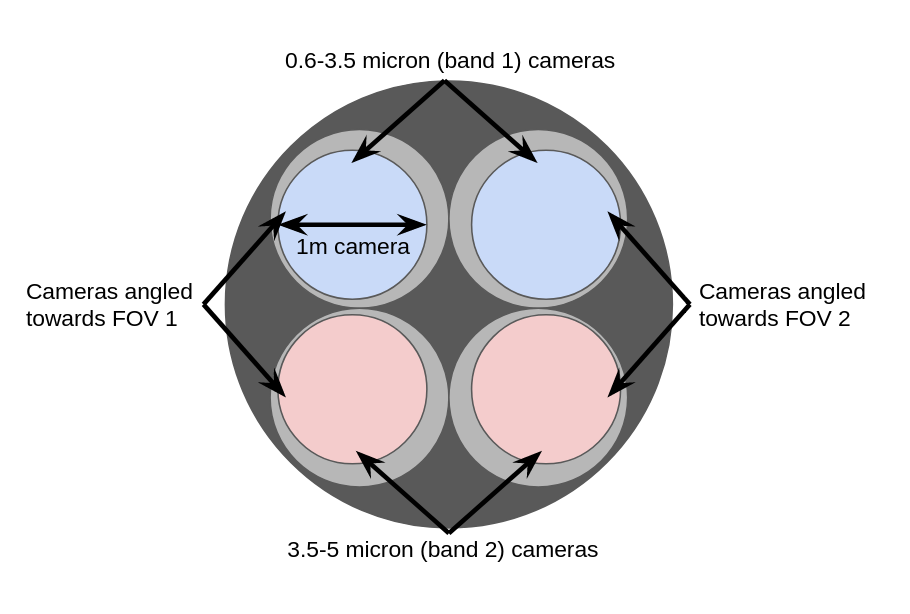

Side-on View


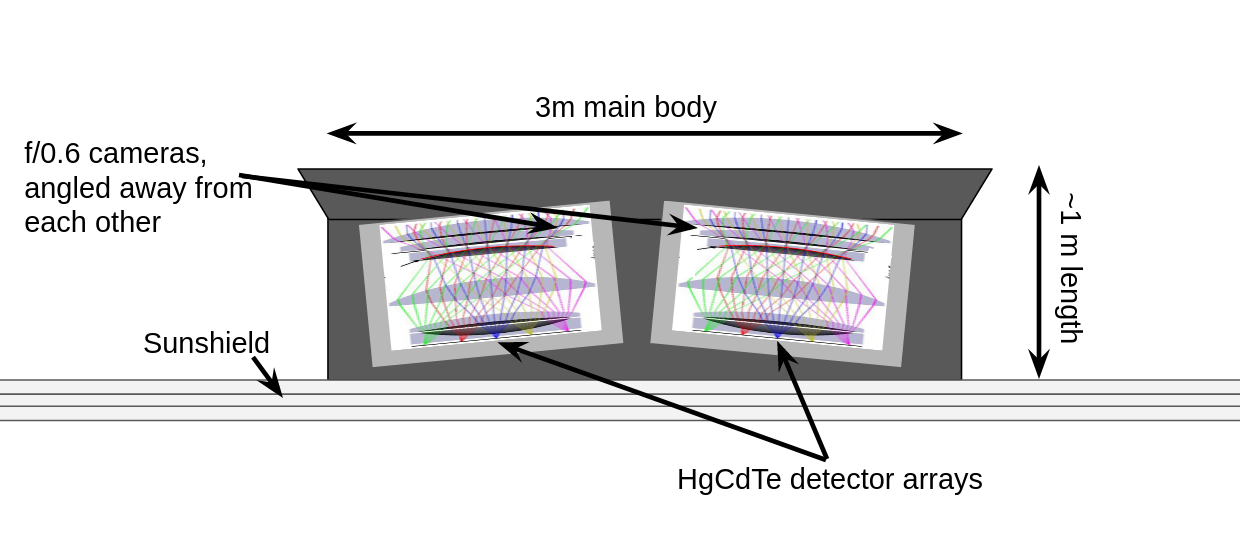

TESS Optics


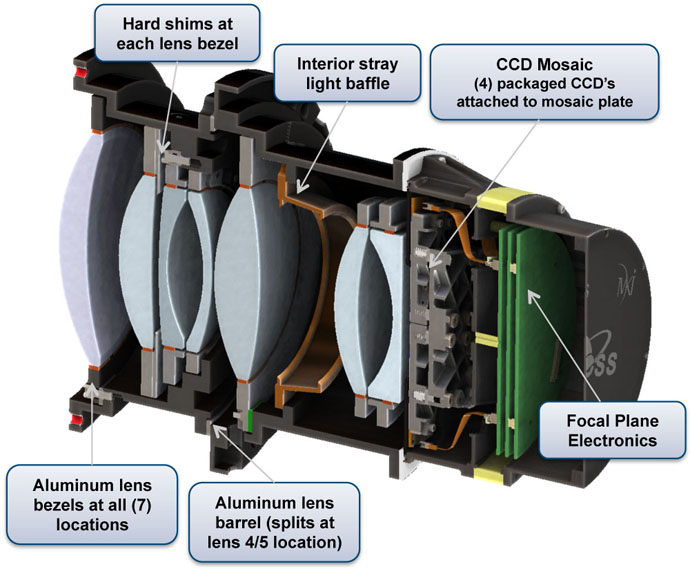

In [18]:
print("Face-on View")
display(Image('InfraTESS_faceon.png', width=600, unconfined=True))

print("Side-on View")
display(Image('InfraTESS_sideon.png', width=600, unconfined=True))


print("TESS Optics")
display(Image('tess_optics.jpg', width=600, unconfined=True))


We find that we require a 1m aperture diameter in order to reach the sensitivity necessary to detect sub-Neptunes around thousands of nearby brown dwarfs. Our usage of complimentary broadband photometry (with filters) will allow for simultaneous imaging in both of our two bands, allowing for easy disentangling of stellar activity and planet transits.
 
Our passbands were carefully selected to make use of existing JWST technology, and involve the usage of detector chips that would be sufficiently cooled purely by using a sunshield.  We hope to make usage of a sunshield similar to that from JWST, scaled down in size to ideally result in a smaller and less risky cooling mechanism.

To allow for further comparisons between this mission and TESS's data, we will adopt an elliptical orbit around the Earth, at a 2:1 resonance with the moon. 

We believe that our costs will be primarily guided by three central issues:
- The detectors.  Unlike TESS, which used reliatively few detector chips, we require around 200 HgCdTe chips. If we assume that the development and manufacturing costs of a high-grade IR chips is around one million dollars, this would contribute \\$200 million to the total cost.
- The lens.  The LSST camera is quoted as having a cost of \\$168 million total, and has a lens of around 1.5m in diameter.   If we assume that lens prices are roughly linear with diameter (which might not necessarily be a great assumption), it appears that each of our four largest primary lenses may cost around \\$100 million each, adding \\$400 million to the total cost.
- The launch.  TESS had an approximately \\$87 million launch cost.  If we assume that the cost of launching into a TESS-like orbit is proportional to the mass of the instrument, and also that the mass of an instrument scales like the diameter of the telescope lens involved (as presumably we'll need more support structures, etc, with a larger lens), it'll probably be around \\$870 million to launch.

Overall, this results in an instrument cost of around \\$1.5 billion.
Unfortunately, the extremely dim nature of brown dwarfs makes it impossible to detect them, even in the infrared, with a mission as economical as TESS.  It is likely that costs in this mission could be cut in the following ways (in order of most reasonable cuts to most damaging cuts):

- Abandon brown dwarfs as science targets, and instead focus on brighter objects in the infrared (various stars?).  This would allow for a smaller aperture, which would also reduce the size of the detector array and the focal length requirements.
- Abandon the concept of multiband simultaneous photometry, instead either imaging only in one band or imaging in separate bands at different times, perhaps using filters.  This would reduce the mission's use with regards to differentiating planetary transits from stellar activity.  However, it would simplify the optics and reduce the size of the detector array.
- Abandon the concept of wide-field photometry, either decreasing the FOV dramatically or re-scoping the project such that only one object is observed at a time.  This would make the instrument only useful for performing follow-up on targets already identified by surveys like, e.g., TESS.
